In [236]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.dates as mdates


In [2]:
Tch_chan = pd.read_pickle("tech_review_channels).p",compression='gzip')

In [3]:
Tch_chan.head(10)

,category_cc,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,tech_videos_perc
0,Science & Technology,2010-12-21,UCsTcErHg8oDvUnTzoqsYeNw,Unbox Therapy,15300000,1672,206.0,2.0870,1221.0,0.730263
1,Science & Technology,2015-10-19,UCOhHO2ICt0ti9KAh-QHvttQ,Technical Guruji,13979890,2539,240.0,2.0870,266.0,0.104766
2,Science & Technology,2008-03-21,UCBJycsmduvYEL83R_U4JriQ,Marques Brownlee,9400000,1148,530.0,2.0870,28.0,0.024390
3,Science & Technology,2008-11-25,UCXuqSBlHAE6Xw-yeJA0Tunw,Linus Tech Tips,9160000,4700,558.0,2.0870,65.0,0.013830
4,Science & Technology,2011-09-06,UCqsS8fU6yVxrJr5y_CoUn3w,HaerteTest,5890000,345,574.0,2.0870,4.0,0.011594
5,Science & Technology,2009-01-27,UCj34AOIMl_k1fF7hcBkD_dw,EverythingApplePro,7630000,1639,826.0,2.0870,42.0,0.025625
6,Science & Technology,2008-05-15,UCSrPuHtKbst7Zy8pyWn_3Cg,What's Inside?,6670000,268,1059.0,2.0870,18.0,0.067164
7,Science & Technology,2015-11-17,UC1tVU8H153ZFO9eRsxdJlhA,Technology Gyan,4480000,464,1612.0,2.0870,99.0,0.213362
8,Science & Technology,2007-08-05,UCXGgrKt94gR6lmN4aN3mYTg,Austin Evans,3880000,1585,2464.0,2.1915,76.0,0.047950
9,Science & Technology,2010-12-29,UCpT9kL2Eba91BB9CK6wJ4Pg,TechSmartt,3570000,1064,2662.0,2.2225,313.0,0.294173


In [76]:
Tch_vid = pd.read_pickle("tech_review_videos.p",compression='gzip')

In [6]:
#Write a function that gives the last date a video was uploaded to a channel
def last_upload_date(channel_id):
    return Tch_vid[Tch_vid['channel_id']==channel_id]['upload_date'].max()




In [8]:
#Now the first date a video was uploaded to a channel
def first_upload_date(channel_id):
    return Tch_vid[Tch_vid['channel_id']==channel_id]['upload_date'].min()

In [10]:

def months_between_dates(date1,date2):
    return (date2.year-date1.year)*12 + (date2.month-date1.month)

In [19]:
#find the number of videos displayed on a channel
def num_videos(channel_id):
    return Tch_vid[Tch_vid['channel_id']==channel_id]['display_id'].count()

In [20]:
Tch_chan['last_upload_date'] = Tch_chan['channel_id'].apply(last_upload_date)

7

In [26]:
#Add column last upload date to Tch_chan
Tch_chan['first_upload_date'] = Tch_chan['channel_id'].apply(first_upload_date)

In [38]:
#Add column months between first and last upload date
Tch_chan['months_between_dates'] = Tch_chan.apply(lambda x: months_between_dates(x['first_upload_date'],x['last_upload_date']),axis=1)

In [42]:
#gIVE THE monthly frequency of uploads as a new column
Tch_chan['monthly_frequency'] = Tch_chan.apply(lambda x:  x['count_tech_videos']/max(1,x['months_between_dates']),axis=1)

In [50]:
Tch_chan_freq = Tch_chan[['channel_id','subscribers_cc' ,'subscriber_rank_sb' ,'monthly_frequency']]

In [51]:
Tch_chan_freq.head(10)

,channel_id,subscribers_cc,subscriber_rank_sb,monthly_frequency
0,UCsTcErHg8oDvUnTzoqsYeNw,15300000,206.0,11.518868
1,UCOhHO2ICt0ti9KAh-QHvttQ,13979890,240.0,5.541667
2,UCBJycsmduvYEL83R_U4JriQ,9400000,530.0,0.239316
3,UCXuqSBlHAE6Xw-yeJA0Tunw,9160000,558.0,0.878378
4,UCqsS8fU6yVxrJr5y_CoUn3w,5890000,574.0,0.266667
5,UCj34AOIMl_k1fF7hcBkD_dw,7630000,826.0,0.375000
6,UCSrPuHtKbst7Zy8pyWn_3Cg,6670000,1059.0,0.461538
7,UC1tVU8H153ZFO9eRsxdJlhA,4480000,1612.0,3.666667
8,UCXGgrKt94gR6lmN4aN3mYTg,3880000,2464.0,0.783505
9,UCpT9kL2Eba91BB9CK6wJ4Pg,3570000,2662.0,3.260417


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/1796813055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tch_chan_freq['Subscriber Category'] = pd.cut(Tch_chan_freq['subscribers_cc'], bins=bin_edges)


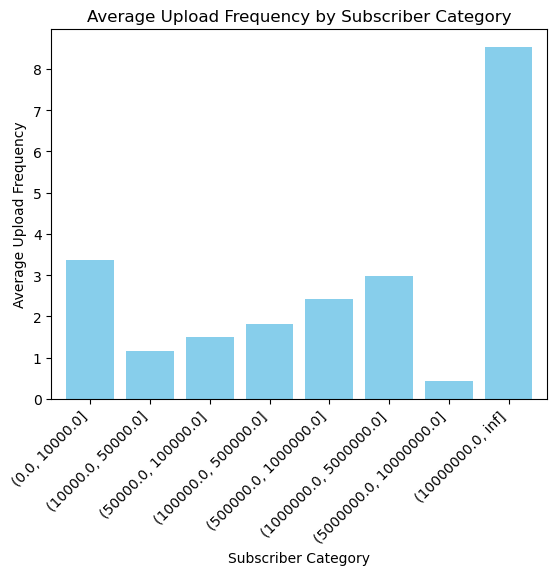

In [52]:
bin_edges = [0, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, float('inf')]

# Create a new column to categorize subscribers into bins
Tch_chan_freq['Subscriber Category'] = pd.cut(Tch_chan_freq['subscribers_cc'], bins=bin_edges)

# Group by the 'Subscriber Category' and calculate the average upload frequency
average_uploads_by_subscribers = Tch_chan_freq.groupby('Subscriber Category')['monthly_frequency'].mean()

# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='skyblue')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


In [58]:

Tch_chan_freq['Rank Category'] = 10 - pd.qcut(Tch_chan_freq['subscriber_rank_sb'], q=10, labels=False)

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/3359942426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tch_chan_freq['Rank Category'] = 10 - pd.qcut(Tch_chan_freq['subscriber_rank_sb'], q=10, labels=False)


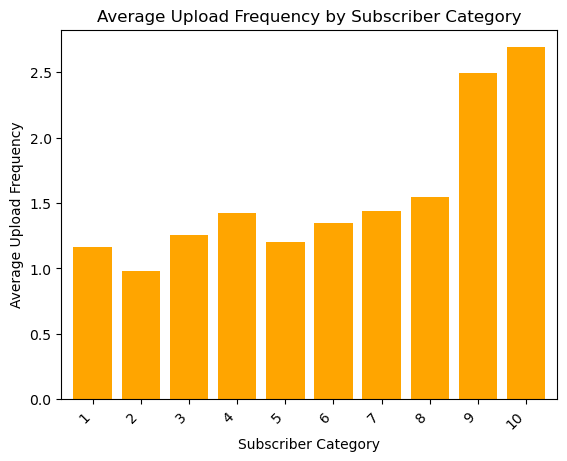

In [61]:
# Group by the 'Rank Category' and calculate the average upload frequency, the cateogry 10 is the top 10% of §ubscribers
average_uploads_by_subscribers = Tch_chan_freq.groupby('Rank Category')['monthly_frequency'].mean()

# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='orange')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

The thing to observe here, it's that very small youtubers upload a lot to try to progress and have more views, and that TOP tier youtuber upload a lot of ivdeos as they are doing it for a living for sure.

# Now , focus only on 4 youtubers , this will be generalized over bunch of youtubers for each category 


In [203]:
mylist =['Marques Brownlee','UrAvgConsumer','Unbox Therapy','Mrwhosetheboss']
list_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ 'channel_id'].unique()
names_and_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ ['name_cc' ,'channel_id']].drop_duplicates()
names_and_ids  

,name_cc,channel_id
0,Unbox Therapy,UCsTcErHg8oDvUnTzoqsYeNw
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ
12,Mrwhosetheboss,UCMiJRAwDNSNzuYeN2uWa0pA
19,UrAvgConsumer,UC9fSZHEh6XsRpX-xJc6lT3A


In [191]:
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json("yt_metadata_en.jsonl.gz", compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date"], inplace=True, axis=1)
    df_json = df_json[(df_json['channel_id'].isin(list_ids))]
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    
    dfs.append(df_json)
yt_metadata = pd.concat(dfs)

Loading data:  55%|█████▌    | 402/729.24794 [13:57<10:52,  1.99s/it]/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/1129483078.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
Loading data:  75%|███████▌  | 550/729.24794 [18:49<07:18,  2.45s/it]/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/1129483078.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_json["upload_date"] = pd.to_datetime(df_json["uploa

In [192]:
Tech_4_VID = yt_metadata

In [204]:
TS = pd.read_table("df_timeseries_en.tsv")

In [206]:
Tech_4_VID['Release_Date'] = pd.to_datetime(Tech_4_VID['upload_date'])

# Sort the DataFrame by 'Release_Date'
Tech_4_VID = Tech_4_VID.sort_values('Release_Date')

In [208]:


TS_4 = TS[TS['channel'].isin(list_ids)]

Tech_4_VID_flt =Tech_4_VID[(TS_4['datetime'].max() >=Tech_4_VID['Release_Date']) & (Tech_4_VID['Release_Date']>= TS_4['datetime'].min())]

UnboxVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCsTcErHg8oDvUnTzoqsYeNw']
MKBHDVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCBJycsmduvYEL83R_U4JriQ']
UrAvgConsumerVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UC9fSZHEh6XsRpX-xJc6lT3A']
MrwhosethebossVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCMiJRAwDNSNzuYeN2uWa0pA']









/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/339186378.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/339186378.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/339186378.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

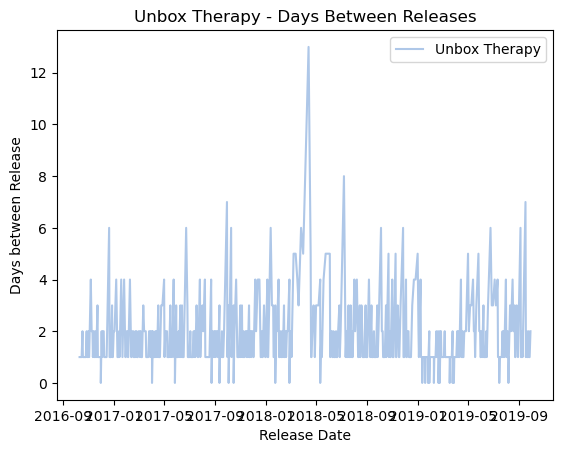

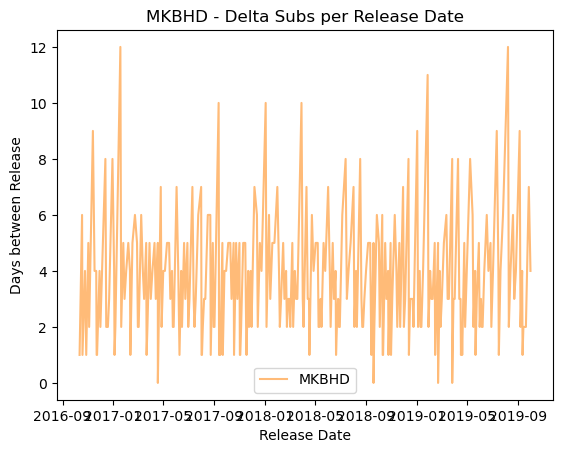

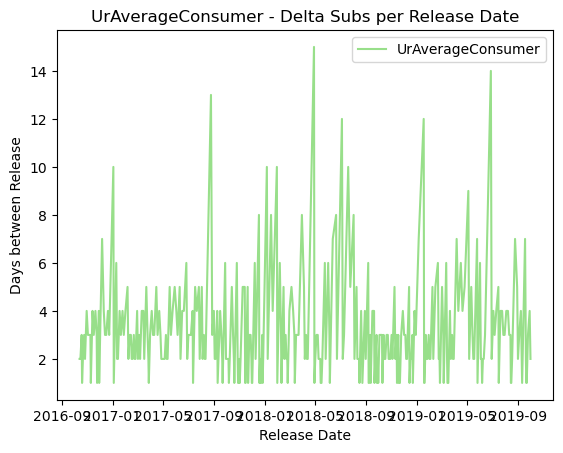

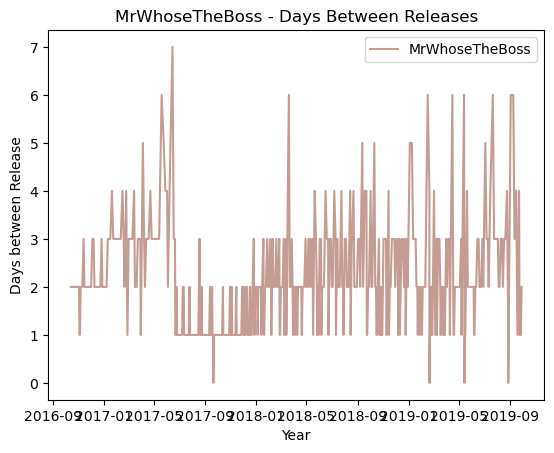

In [353]:


# Calculate the time difference between releases
UnboxVID['Days_Between_Releases'] = UnboxVID['Release_Date'].diff().dt.days
UnboxVID['Frequency'] = 1/UnboxVID['Days_Between_Releases']

MKBHDVID['Days_Between_Releases'] = MKBHDVID['Release_Date'].diff().dt.days
MKBHDVID['Frequency'] = 1/MKBHDVID['Days_Between_Releases']

UrAvgConsumerVID['Days_Between_Releases'] = UrAvgConsumerVID['Release_Date'].diff().dt.days
UrAvgConsumerVID['Frequency'] = 1/UrAvgConsumerVID['Days_Between_Releases']

MrwhosethebossVID['Days_Between_Releases'] = MrwhosethebossVID['Release_Date'].diff().dt.days
MrwhosethebossVID['Frequency'] = 1/MrwhosethebossVID['Days_Between_Releases']



#Plotting the curves for Unbox Therapy
plt.figure(1)
plt.plot(UnboxVID['Release_Date'], UnboxVID['Days_Between_Releases'], label='Unbox Therapy', color='#aec7e8')
plt.xlabel('Release Date')
plt.ylabel('Days between Release')
plt.title('Unbox Therapy - Days Between Releases')
plt.legend()

# Plotting the curves for MKBHD
plt.figure(2)
plt.plot(MKBHDVID['Release_Date'], MKBHDVID['Days_Between_Releases'], label='MKBHD', color='#ffbb78')
plt.xlabel('Release Date')
plt.ylabel('Days between Release')
plt.title('MKBHD - Delta Subs per Release Date')
plt.legend()

# Plotting the curves for UrAverageConsumer
plt.figure(3)
plt.plot(UrAvgConsumerVID['Release_Date'], UrAvgConsumerVID['Days_Between_Releases'], label='UrAverageConsumer', color='#98df8a')
plt.xlabel('Release Date')
plt.ylabel('Days between Release')
plt.title('UrAverageConsumer - Delta Subs per Release Date')
plt.legend()

# Plotting the curves for MrWhoseTheBoss
plt.figure(4)
plt.plot(MrwhosethebossVID['Release_Date'], MrwhosethebossVID['Days_Between_Releases'], label='MrWhoseTheBoss', color='#c49c94')
plt.xlabel('Year')
plt.ylabel('Days between Release')
plt.title('MrWhoseTheBoss - Days Between Releases')
plt.legend()

# Display the plots
plt.show()

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/3263196072.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/3263196072.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/3263196072.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

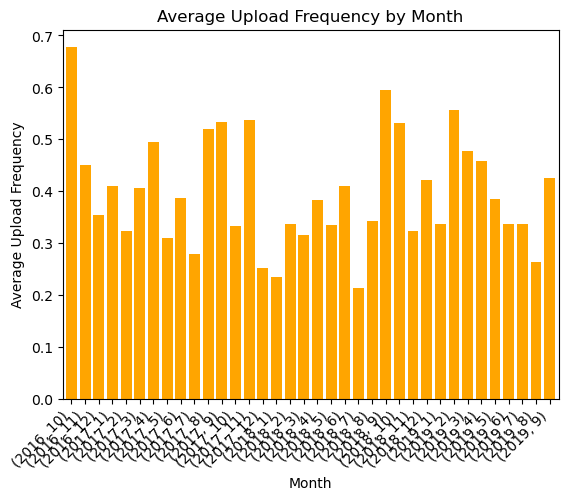

In [351]:
#Averaging yearly frequency
MKBHDVID['Year'] = MKBHDVID['Release_Date'].dt.year
MKBHDVID['Month'] = MKBHDVID['Release_Date'].dt.month
MKBHDVID['Days_Between_Releases'] = MKBHDVID['Days_Between_Releases'].fillna(1)
#change the 0s in days between releases  into 1/2 
MKBHDVID['Days_Between_Releases'] = MKBHDVID['Days_Between_Releases'].replace(0,0.5)
MKBHDVID['Frequency'] = 1/MKBHDVID['Days_Between_Releases']


#do the same for other youtubers
UnboxVID['Year'] = UnboxVID['Release_Date'].dt.year
UnboxVID['Month'] = UnboxVID['Release_Date'].dt.month
UnboxVID['Days_Between_Releases'] = UnboxVID['Days_Between_Releases'].fillna(1)
#change the 0s in days between releases  into 1/2
UnboxVID['Days_Between_Releases'] = UnboxVID['Days_Between_Releases'].replace(0,0.5)
UnboxVID['Frequency'] = 1/UnboxVID['Days_Between_Releases']

UrAvgConsumerVID['Year'] = UrAvgConsumerVID['Release_Date'].dt.year
UrAvgConsumerVID['Month'] = UrAvgConsumerVID['Release_Date'].dt.month
UrAvgConsumerVID['Days_Between_Releases'] = UrAvgConsumerVID['Days_Between_Releases'].fillna(1)
#change the 0s in days between releases  into 1/2
UrAvgConsumerVID['Days_Between_Releases'] = UrAvgConsumerVID['Days_Between_Releases'].replace(0,0.5)
UrAvgConsumerVID['Frequency'] = 1/UrAvgConsumerVID['Days_Between_Releases']

MrwhosethebossVID['Year'] = MrwhosethebossVID['Release_Date'].dt.year
MrwhosethebossVID['Month'] = MrwhosethebossVID['Release_Date'].dt.month
MrwhosethebossVID['Days_Between_Releases'] = MrwhosethebossVID['Days_Between_Releases'].fillna(1)
#change the 0s in days between releases  into 1/2
MrwhosethebossVID['Days_Between_Releases'] = MrwhosethebossVID['Days_Between_Releases'].replace(0,0.5)
MrwhosethebossVID['Frequency'] = 1/MrwhosethebossVID['Days_Between_Releases']

#add the frequency grouped by year and month to the dataframe MKBHDVID



# Group by the 'Year' and calculate the average upload frequency
average_uploads_by_month = MKBHDVID.groupby(['Year','Month'])['Frequency'].mean()

# Plot the histogram
average_uploads_by_month.plot(kind='bar', width=0.8, color='orange')
plt.title('Average Upload Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()





#I considered here that if the day between two releases is 0 that means that he uploaded two videos in the same day, in reality he may have uploaded more.







/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/othmaneio/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:848: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




<Figure size 3000x1700 with 0 Axes>

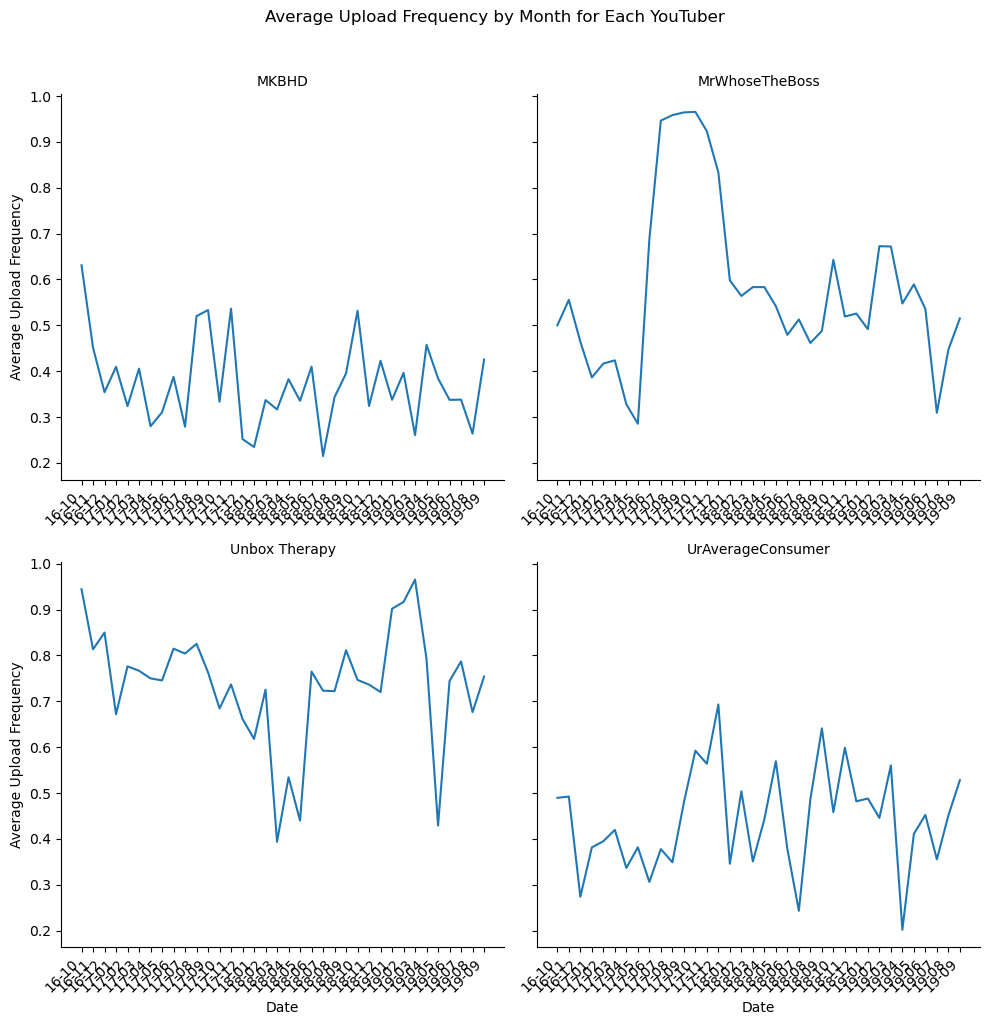

In [346]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have four DataFrames: youtuber1_df, youtuber2_df, youtuber3_df, youtuber4_df

# Add a 'Youtuber' column to each DataFrame



# Set a wider figure size
plt.figure(figsize=(30, 17))

# Use seaborn to create a FacetGrid with one subplot for each Youtuber
g = sns.FacetGrid(combined_df, col='Youtuber', col_wrap=2, height=5, margin_titles=True, sharex=False)
g.map_dataframe(sns.lineplot, x='FormattedDate', y='Frequency', ci=None)
g.set_axis_labels('Date', 'Average Upload Frequency')
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=45, ha='right')

plt.suptitle('Average Upload Frequency by Month for Each YouTuber', y=1.02)
plt.tight_layout()
plt.show()

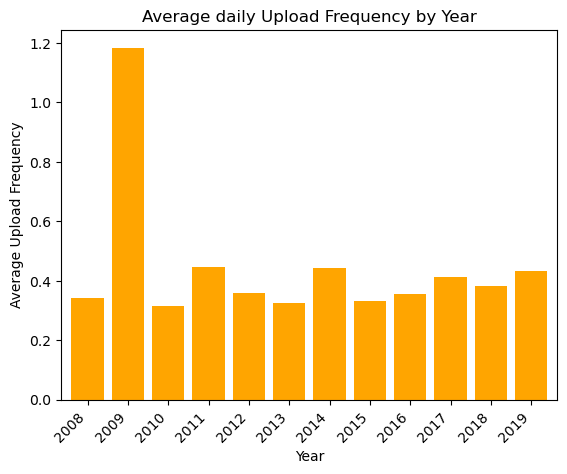

In [135]:
#plot year and average_uploads_by_year as histogram
average_uploads_by_year.plot(kind='bar', width=0.8, color='orange')
plt.title('Average daily Upload Frequency by Year')
plt.xlabel('Year')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()



In [266]:
#plot the count of videos per year
MKBHDVID['MonthlyReleases'] = MKBHDVID.groupby(['Year', 'Month'])['display_id'].transform('count')
UnboxVID['MonthlyReleases'] = UnboxVID.groupby(['Year', 'Month'])['display_id'].transform('count')
UrAvgConsumerVID['MonthlyReleases'] = UrAvgConsumerVID.groupby(['Year', 'Month'])['display_id'].transform('count')
MrwhosethebossVID['MonthlyReleases'] = MrwhosethebossVID.groupby(['Year', 'Month'])['display_id'].transform('count')







/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/2990482117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MKBHDVID['MonthlyReleases'] = MKBHDVID.groupby(['Year', 'Month'])['display_id'].transform('count')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/2990482117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UnboxVID['MonthlyReleases'] = UnboxVID.groupby(['Year', 'Month'])['display_id'].transform('count')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel

In [272]:
TS_MKBHD = TS_4[TS_4['channel']=='UCBJycsmduvYEL83R_U4JriQ']
TS_Unbox = TS_4[TS_4['channel']=='UCsTcErHg8oDvUnTzoqsYeNw']
TS_UrAvgConsumer = TS_4[TS_4['channel']=='UC9fSZHEh6XsRpX-xJc6lT3A']
TS_Mrwhosetheboss = TS_4[TS_4['channel']=='UCMiJRAwDNSNzuYeN2uWa0pA']

In [348]:
TS_MKBHD['datetime'] = pd.to_datetime(TS_MKBHD['datetime'])
TS_MKBHD['Year'] = TS_MKBHD['datetime'].dt.year
TS_MKBHD['Month'] = TS_MKBHD['datetime'].dt.month

TS_Unbox['datetime'] = pd.to_datetime(TS_Unbox['datetime'])
TS_Unbox['Year'] = TS_Unbox['datetime'].dt.year
TS_Unbox['Month'] = TS_Unbox['datetime'].dt.month

TS_UrAvgConsumer['datetime'] = pd.to_datetime(TS_UrAvgConsumer['datetime'])
TS_UrAvgConsumer['Year'] = TS_UrAvgConsumer['datetime'].dt.year
TS_UrAvgConsumer['Month'] = TS_UrAvgConsumer['datetime'].dt.month

TS_Mrwhosetheboss['datetime'] = pd.to_datetime(TS_Mrwhosetheboss['datetime'])
TS_Mrwhosetheboss['Year'] = TS_Mrwhosetheboss['datetime'].dt.year
TS_Mrwhosetheboss['Month'] = TS_Mrwhosetheboss['datetime'].dt.month



# Group by the 'Year' column and sum the 'Delta_Sub' values for each month of each year
yearlyTS_MKBHD = TS_MKBHD.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max', 'delta_videos': 'sum'}).reset_index()
yearlyTS_Unbox = TS_Unbox.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max', 'delta_videos':'sum'}).reset_index()
yearlyTS_UrAvgConsumer = TS_UrAvgConsumer.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max', 'delta_videos':'sum'}).reset_index()
yearlyTS_Mrwhosetheboss = TS_Mrwhosetheboss.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max', 'delta_videos':'sum'}).reset_index()




/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/2223096486.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/2223096486.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/2223096486.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

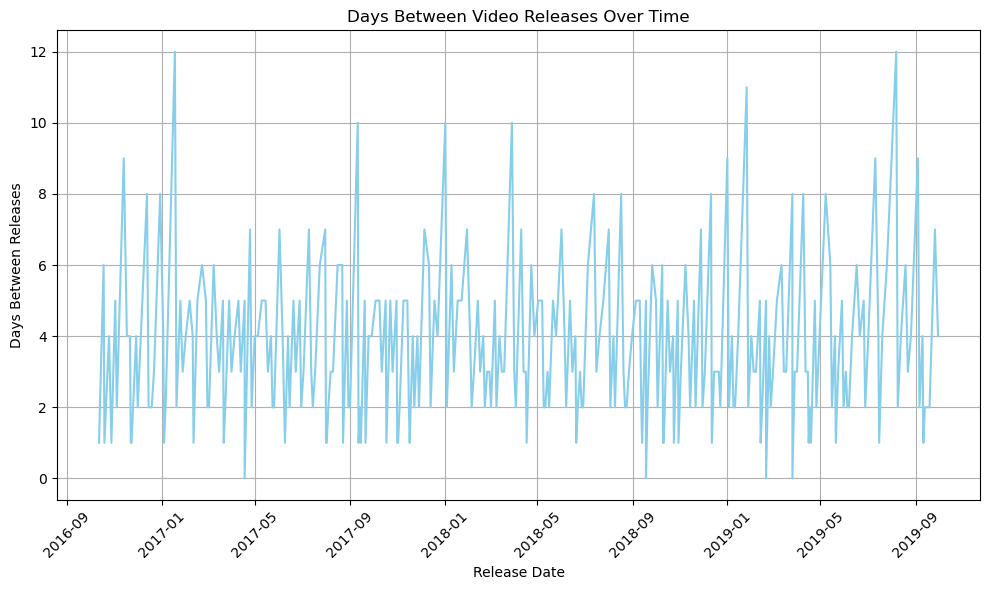

In [297]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(MKBHDVID['Release_Date'], MKBHDVID['Days_Between_Releases'], linestyle='-', color='skyblue')
plt.title('Days Between Video Releases Over Time')
plt.xlabel('Release Date')
plt.ylabel('Days Between Releases')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/4152694631.py:19: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_40110/4152694631.py:25: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




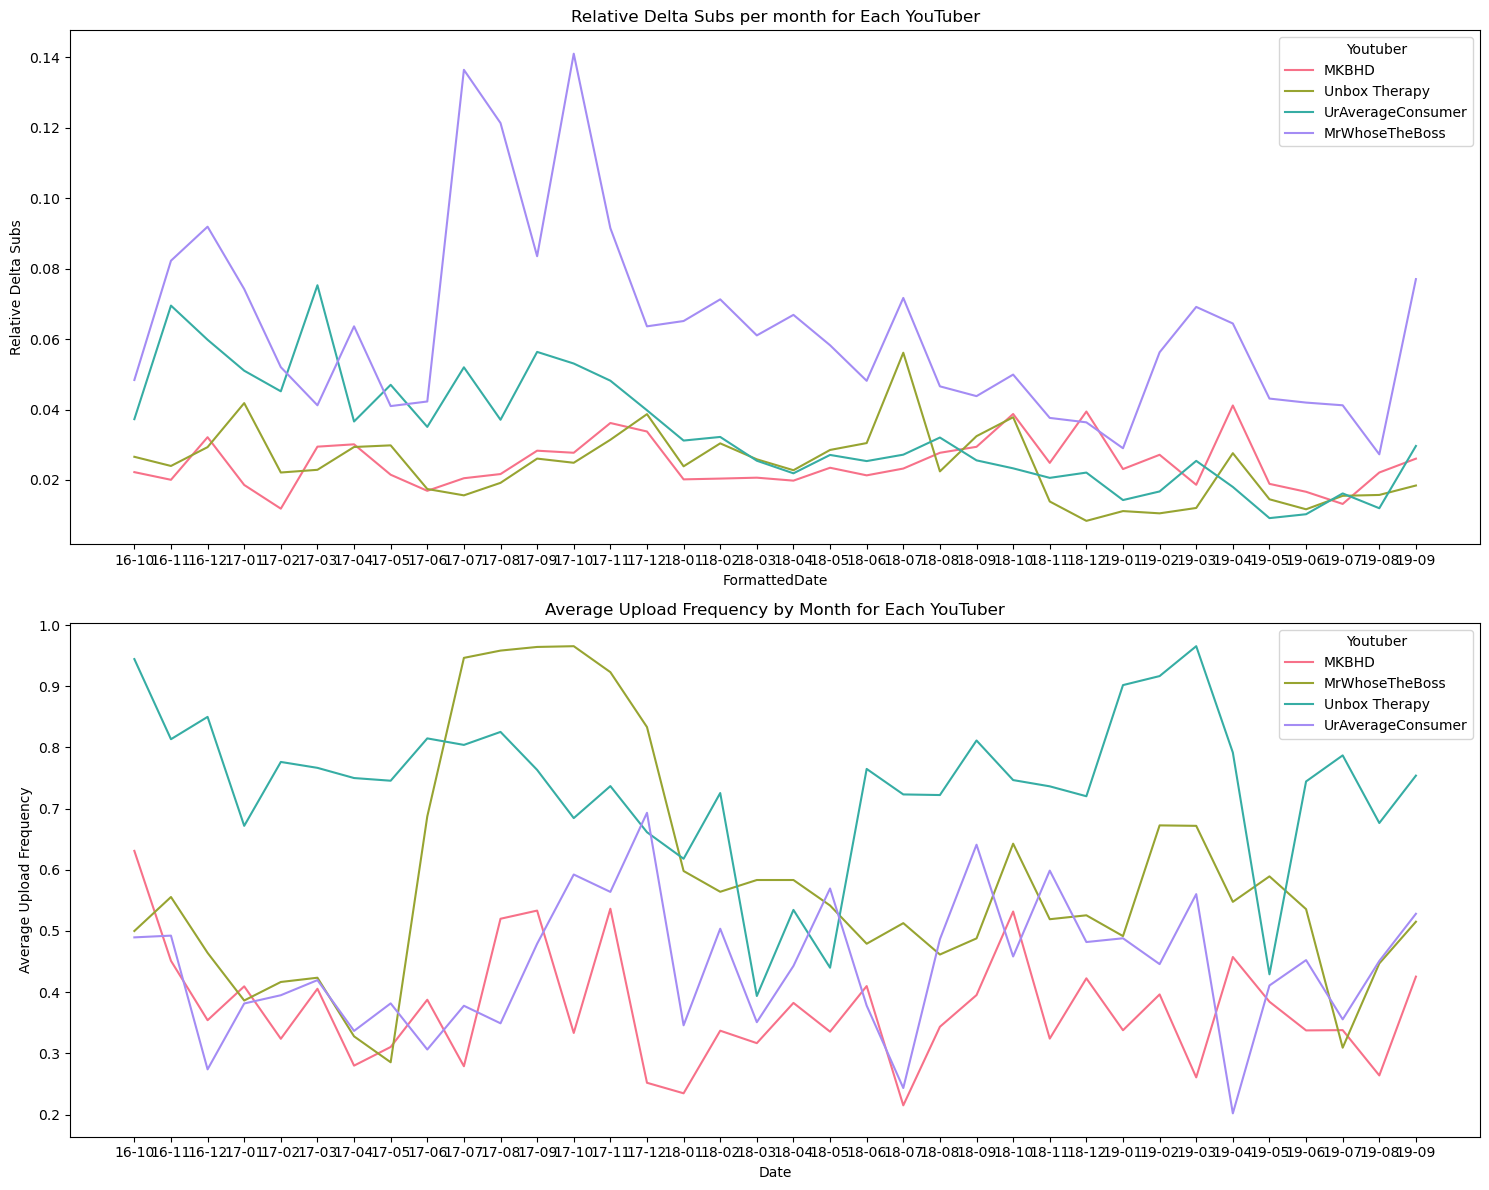

In [341]:
combined_df_subs = pd.concat([yearlyTS_MKBHD, yearlyTS_Unbox, yearlyTS_UrAvgConsumer, yearlyTS_Mrwhosetheboss])

# Convert 'Year' and 'Month' to datetime format and create a new 'Date' column
combined_df_subs['Date'] = pd.to_datetime(combined_df_subs[['Year', 'Month']].assign(DAY=1))

# Format the 'Date' column as 'YY-MM'
combined_df_subs['FormattedDate'] = combined_df_subs['Date'].dt.strftime('%y-%m')

# Sort the DataFrame by the 'Date' column
combined_df_subs = combined_df_subs.sort_values(by='Date')

# Define a consistent palette for Youtubers
youtuber_palette = sns.color_palette("husl", n_colors=len(combined_df_subs['Youtuber'].unique()))

# Create subplots with a consistent palette
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)

# ---- First Subplot: Relative Delta Subs per month ----
sns.lineplot(x='FormattedDate', y='RelativeDeltaSubs', hue='Youtuber', data=combined_df_subs, ci=None, ax=ax1, palette=youtuber_palette)
ax1.set_title('Relative Delta Subs per month for Each YouTuber')
ax1.set_ylabel('Relative Delta Subs')
ax1.legend(title='Youtuber')

# ---- Second Subplot: Average Upload Frequency per month ----
sns.lineplot(x='FormattedDate', y='Frequency', hue='Youtuber', data=combined_df_freq, ci=None, ax=ax2, palette=youtuber_palette)
ax2.set_title('Average Upload Frequency by Month for Each YouTuber')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Upload Frequency')
ax2.legend(title='Youtuber')

# Adjust layout
plt.tight_layout()
plt.show()

Here we canno't observe really well the evolution as Unbox therapy has much more subscribers than the others

In [338]:
import plotly.express as px
from plotly.subplots import make_subplots

# Assuming the necessary dataframes are defined

# Create subplots for each Youtuber for Relative Delta Subs
fig_subs = px.line(combined_df_subs, x='FormattedDate', y='RelativeDeltaSubs', color='Youtuber',
                facet_col='Youtuber', facet_col_wrap=2, labels={'RelativeDeltaSubs': 'Relative Delta Subs'})

# Set layout title for Relative Delta Subs
fig_subs.update_layout(title='Relative Delta Subs per month for Each YouTuber')

# Create subplots for each Youtuber for Average Upload Frequency
fig_freq = px.line(combined_df_subs, x='FormattedDate', y='delta_videos', color='Youtuber',
                facet_col='Youtuber', facet_col_wrap=2, labels={'Videos': 'Number of videos'})

# Set layout title for Average Upload Frequency
fig_freq.update_layout(title='Number of videos per month for Each YouTuber')

# Combine the two figures
fig_combined = make_subplots(rows=2, cols=1, subplot_titles=('Relative Delta Subs', 'Number of videos per month'))

# Add the Relative Delta Subs subplot to the combined figure
for trace in fig_subs.data:
    fig_combined.add_trace(trace, row=1, col=1)

# Add the Average Upload Frequency subplot to the combined figure
for trace in fig_freq.data:
    fig_combined.add_trace(trace, row=2, col=1)

# Update layout
fig_combined.update_layout(height=800, showlegend=False)

# Show the combined figure
fig_combined.show()

We can clearly observe the same trend, this is to be explored more generally     

In [291]:
#write in pickle file Tech_4_VID
Tech_4_VID.to_pickle("Tech_4_VID.p")